# Importing the libraries

In [101]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as func
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
import io
import os
import zipfile
import random 
import math
import unicodedata
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

# Load File in Drive

In [63]:
!wget 'http://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip'

!unzip 'household_power_consumption.zip'

--2023-04-07 14:19:54--  http://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20640916 (20M) [application/x-httpd-php]
Saving to: ‘household_power_consumption.zip.1’

household_power_con 100%[===================>]  19.68M  8.79MB/s    in 2.2s    

2023-04-07 14:19:57 (8.79 MB/s) - ‘household_power_consumption.zip.1’ saved [20640916/20640916]

Archive:  household_power_consumption.zip
replace household_power_consumption.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Loading the dataset

In [102]:
path = '/content/household_power_consumption.txt'
df = pd.read_csv(path, delimiter=';', 
                  infer_datetime_format=True, 
                 na_values=['nan','?'])

In [103]:
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [66]:
df.dropna(inplace=True)

In [67]:
# Extract the input features and target variable from the dataframe
X = df.iloc[:,3:].values
y = df.iloc[:, 2:3].values

# Dataset Split

In [68]:
def splitDataset(X, y, test_size):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)

  return X_train, X_test, y_train, y_test

# Convert dataset to tensor

In [69]:
def convertToTonsor(x):
  return torch.tensor(x, dtype=torch.float32)

# Hyperparamater

In [70]:
input_size = X.shape[1]
hidden_size = 64
num_layers = 2
output_size = 1
learning_rate = 0.0001
batch_size = 32
num_epochs = 10

# for 80:20

## Split dataset 80:20

In [71]:
# Split dataset into 80:20
X_train, X_test, y_train, y_test = splitDataset(X, y, 0.2)
print(type(X_train), len(X_train))
print(type(X_test), len(X_test))
print(type(y_train), len(y_train))
print(type(y_test), len(y_test))


# Convert the input features and target variable into PyTorch tensors

X_train = convertToTonsor(X_train)
print(type(X_train), len(X_train))


y_train = convertToTonsor(y_train)
print(type(y_train), len(y_train))

X_test = convertToTonsor(X_test)
print(type(X_test), len(X_test))

y_test = convertToTonsor(y_test)
print(type(y_test), len(y_test))

<class 'numpy.ndarray'> 1639424
<class 'numpy.ndarray'> 409856
<class 'numpy.ndarray'> 1639424
<class 'numpy.ndarray'> 409856
<class 'torch.Tensor'> 1639424
<class 'torch.Tensor'> 1639424
<class 'torch.Tensor'> 409856
<class 'torch.Tensor'> 409856


## Create dataset for 80:20

In [72]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

In [73]:
print("Len of train : ",len(train_dataset))
print("Len of test : ",len(test_dataset))

Len of train :  1639424
Len of test :  409856


## data preprocessing for 80:20

In [74]:
def msn(x):
  x_mean = x.mean(dim=0)
  x_std  = x.std(dim=0)
  return x_mean, x_std, (x - x_mean) / x_std

In [75]:
X_train_mean, X_train_std, X_train_norm = msn(X_train)

print(X_train_mean)
print(X_train_std)
print(X_train_norm)

tensor([1.2377e-01, 2.4084e+02, 4.6292e+00, 1.1250e+00, 1.2984e+00, 6.4584e+00])
tensor([0.1128, 3.2398, 4.4464, 6.1619, 5.8209, 8.4381])
tensor([[-0.4237,  0.7841,  0.3533, -0.0203, -0.0513,  1.3678],
        [ 0.8712, -1.0062,  0.6232, -0.1826, -0.0513,  1.2493],
        [-1.0977,  1.7070, -0.8162, -0.1826, -0.2231, -0.7654],
        ...,
        [ 0.5342,  0.5557, -0.5913, -0.1826, -0.2231, -0.7654],
        [-0.1399, -0.9568, -0.7712, -0.1826, -0.2231, -0.7654],
        [-0.6188, -0.5401, -0.6813, -0.1826, -0.2231, -0.7654]])


In [76]:
X_test_mean, X_test_std, X_test_norm = msn(X_test)

print(X_test_mean)
print(X_test_std)
print(X_test_norm)

tensor([1.2348e-01, 2.4084e+02, 4.6222e+00, 1.1097e+00, 1.2989e+00, 6.4585e+00])
tensor([0.1126, 3.2409, 4.4365, 6.1174, 5.8264, 8.4334])
tensor([[ 1.4789, -1.6694,  3.6916, -0.1814,  4.0679,  1.3685],
        [-1.0967,  1.6044, -0.9968, -0.1814, -0.2229, -0.7658],
        [ 1.4256, -1.4380,  1.4376, -0.1814,  0.2920,  1.2500],
        ...,
        [ 0.8217, -1.3701,  1.0769, -0.1814, -0.2229,  2.4357],
        [ 0.3243,  0.0740, -0.6812, -0.1814, -0.2229, -0.6472],
        [-1.0967,  1.3576, -0.8164, -0.1814, -0.2229, -0.7658]])


In [77]:
y_train_mean, y_train_std, y_train_norm = msn(y_train)

print(y_train_mean)
print(y_train_std)
print(y_train_norm)

tensor([1.0919])
tensor([1.0577])
tensor([[ 0.3896],
        [ 0.6335],
        [-0.8092],
        ...,
        [-0.5653],
        [-0.7846],
        [-0.6750]])


In [78]:
y_test_mean, y_test_std, y_test_norm = msn(y_test)

print(y_test_mean)
print(y_test_std)
print(y_test_norm)

tensor([1.0904])
tensor([1.0556])
tensor([[ 3.6318],
        [-0.9534],
        [ 1.4415],
        ...,
        [ 1.0702],
        [-0.7469],
        [-0.8132]])


## dataloader for 80:20

In [79]:

# Create training dataloader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create testing dataloader
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Cuda device

In [80]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# LSTM Model

In [81]:
class CustomLSTM(nn.Module):
    def __init__(self, input_sz, hidden_sz):
        super().__init__()
        self.input_sz = input_sz
        self.hidden_size = hidden_sz
        self.W = nn.Parameter(torch.Tensor(input_sz, hidden_sz * 4))
        self.U = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz * 4))
        self.bias = nn.Parameter(torch.Tensor(hidden_sz * 4))
        self.init_weights()
        self.fc = nn.Linear(hidden_size, output_size)
                
    def init_weights(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)
         
    def forward(self, x, init_states=None):
        """Assumes x is of shape (batch, sequence, feature)"""
        bs, seq_sz = x.size()
        hidden_seq = []
        if init_states is None:
            h_t, c_t = (torch.zeros(bs, self.hidden_size).to(x.device), 
                        torch.zeros(bs, self.hidden_size).to(x.device))
        else:
            h_t, c_t = init_states
         
        HS = self.hidden_size
        for t in range(seq_sz):
            # print(x.shape)
            x_t = x[t, :]
            # batch the computations into a single matrix multiplication
            gates = x_t @ self.W + h_t @ self.U + self.bias
            i_t, f_t, g_t, o_t = (
                torch.sigmoid(gates[:, :HS]), # input
                torch.sigmoid(gates[:, HS:HS*2]), # forget
                torch.tanh(gates[:, HS*2:HS*3]),
                torch.sigmoid(gates[:, HS*3:]), # output
            )
            c_t = f_t * c_t + i_t * g_t
            h_t = o_t * torch.tanh(c_t)
            hidden_seq.append(h_t.unsqueeze(0))
        hidden_seq = torch.cat(hidden_seq, dim=0)
        # reshape from shape (sequence, batch, feature) to (batch, sequence, feature)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        hidden_seq, (h_t, c_t)

        hidden_seq = self.fc(hidden_seq[:, -1, :])
        return hidden_seq

# Initialize the model, loss function, and optimizer
model = CustomLSTM(input_size, hidden_size)

# Define the loss function and optimizer

In [82]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Train the model

In [83]:
train_loss_list = []

for epoch in range(num_epochs):
    train_loss = 0.0
    for i, (inputs, targets) in enumerate(train_dataloader):
        inputs = (inputs - X_train_mean) / X_train_std # normalize the inputs

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        if (i + 1) % batch_size == 0: # Update the model after every batch_size iterations
            optimizer.step()
            optimizer.zero_grad()

        train_loss /= len(train_dataloader)
    train_loss_list.append(train_loss)
    print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, len(train_dataloader), loss.item()))


Epoch [1/10], Step [51232/51232], Loss: 0.6400
Epoch [2/10], Step [51232/51232], Loss: 1.1213
Epoch [3/10], Step [51232/51232], Loss: 1.3863
Epoch [4/10], Step [51232/51232], Loss: 1.1861
Epoch [5/10], Step [51232/51232], Loss: 1.1500
Epoch [6/10], Step [51232/51232], Loss: 0.7950
Epoch [7/10], Step [51232/51232], Loss: 0.8015
Epoch [8/10], Step [51232/51232], Loss: 0.7779
Epoch [9/10], Step [51232/51232], Loss: 1.2693
Epoch [10/10], Step [51232/51232], Loss: 1.0491


In [84]:
print(len(train_loss_list))

10


# Plot the loss

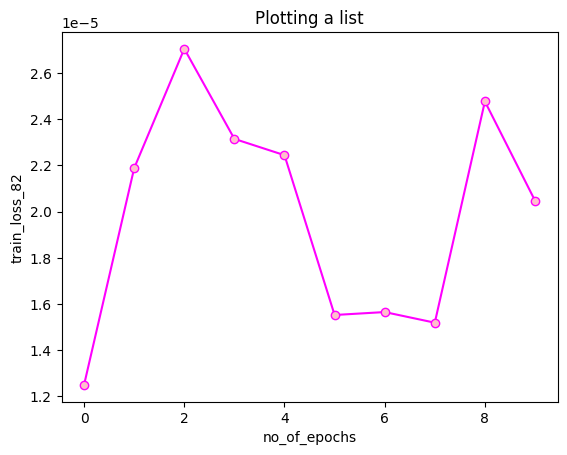

In [85]:
epoch = [epoch for epoch in range(num_epochs)]
plt.plot(epoch,train_loss_list, color='magenta', marker='o',mfc='pink' )
plt.ylabel('train_loss_82') #set the label for x-axis
plt.xlabel('no_of_epochs') #set the label for y axis
plt.title("Plotting a list") #set the title of the graph
plt.show() #display the graph

# Test the model and get the predicted value

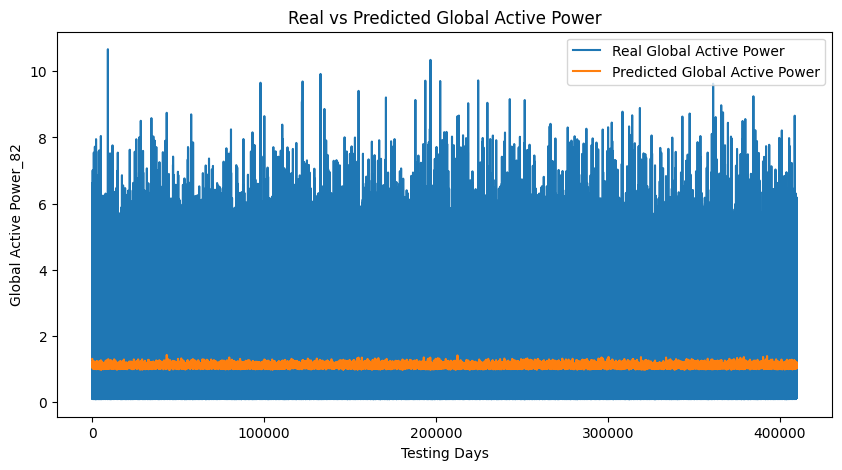

In [86]:
# Set model to evaluation mode
model.eval()

# Initialize lists to store real and predicted global active power
real_global_active_power = []
predicted_global_active_power = []

# Iterate over the testing dataloader
for i, (inputs, targets) in enumerate(test_dataloader):
    inputs = (inputs - X_test_mean) / X_test_std # normalize the inputs

    # Forward pass to get predicted global active power
    outputs = model(inputs)
    predicted_global_active_power.extend(outputs.detach().numpy().tolist())

    # Append real global active power to list
    real_global_active_power.extend(targets.numpy().tolist())

# Convert the lists to numpy arrays for plotting
real_global_active_power = np.array(real_global_active_power)
predicted_global_active_power = np.array(predicted_global_active_power)

# Plot the real and predicted global active power
plt.figure(figsize=(10, 5))
plt.plot(real_global_active_power, label='Real Global Active Power')
plt.plot(predicted_global_active_power, label='Predicted Global Active Power')
plt.xlabel('Testing Days')
plt.ylabel('Global Active Power_82')
plt.legend()
plt.title('Real vs Predicted Global Active Power')
plt.show()


# For 70:30

## Splitting into 70:30

In [87]:
# Split dataset into 70:30
X_train, X_test, y_train, y_test = splitDataset(X, y, 0.3)
print(type(X_train), len(X_train))
print(type(X_test), len(X_test))
print(type(y_train), len(y_train))
print(type(y_test), len(y_test))


# Convert the input features and target variable into PyTorch tensors

X_train = convertToTonsor(X_train)
print(type(X_train), len(X_train))


y_train = convertToTonsor(y_train)
print(type(y_train), len(y_train))

X_test = convertToTonsor(X_test)
print(type(X_test), len(X_test))

y_test = convertToTonsor(y_test)
print(type(y_test), len(y_test))


<class 'numpy.ndarray'> 1434496
<class 'numpy.ndarray'> 614784
<class 'numpy.ndarray'> 1434496
<class 'numpy.ndarray'> 614784
<class 'torch.Tensor'> 1434496
<class 'torch.Tensor'> 1434496
<class 'torch.Tensor'> 614784
<class 'torch.Tensor'> 614784


## Create dataset for 70:30

In [88]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

In [89]:
print("Len of train : ",len(train_dataset))
print("Len of test : ",len(test_dataset))

Len of train :  1434496
Len of test :  614784


## Data preprocessing for 70;30

In [90]:
def msn(x):
  x_mean = x.mean(dim=0)
  x_std  = x.std(dim=0)
  return x_mean, x_std, (x - x_mean) / x_std

In [91]:
X_train_mean, X_train_std, X_train_norm = msn(X_train)

print(X_train_mean)
print(X_train_std)
print(X_train_norm)

tensor([1.2373e-01, 2.4084e+02, 4.6285e+00, 1.1215e+00, 1.3008e+00, 6.4550e+00])
tensor([0.1127, 3.2406, 4.4466, 6.1514, 5.8311, 8.4369])
tensor([[ 0.7832, -0.0650,  0.7133,  0.1428, -0.2231,  1.3684],
        [-0.1396, -0.0033,  0.2185, -0.1823, -0.2231,  1.3684],
        [ 1.6350,  1.8729,  0.4434, -0.1823,  0.1199,  1.4869],
        ...,
        [ 0.5348,  0.5552, -0.5911, -0.1823, -0.2231, -0.7651],
        [-0.1396, -0.9568, -0.7710, -0.1823, -0.2231, -0.7651],
        [-0.6187, -0.5403, -0.6811, -0.1823, -0.2231, -0.7651]])


In [92]:
X_test_mean, X_test_std, X_test_norm = msn(X_test)

print(X_test_mean)
print(X_test_std)
print(X_test_norm)

tensor([1.2368e-01, 2.4084e+02, 4.6261e+00, 1.1229e+00, 1.2931e+00, 6.4664e+00])
tensor([0.1128, 3.2386, 4.4394, 6.1569, 5.8009, 8.4378])
tensor([[ 1.4750, -1.6698,  3.6884, -0.1824,  4.0868,  1.3669],
        [-1.0969,  1.6064, -0.9970, -0.1824, -0.2229, -0.7664],
        [ 1.4218, -1.4382,  1.4358, -0.1824,  0.2942,  1.2484],
        ...,
        [-0.6180, -0.1691,  0.2194, -0.1824, -0.2229,  1.3669],
        [-1.0969,  0.2508, -0.9069, -0.1824, -0.2229, -0.7664],
        [ 1.1735, -0.7805,  0.4446, -0.0200, -0.2229,  1.2484]])


In [93]:
y_train_mean, y_train_std, y_train_norm = msn(y_train)

print(y_train_mean)
print(y_train_std)
print(y_train_norm)

tensor([1.0918])
tensor([1.0578])
tensor([[ 0.7319],
        [ 0.2649],
        [ 0.5145],
        ...,
        [-0.5651],
        [-0.7844],
        [-0.6748]])


In [94]:
y_test_mean, y_test_std, y_test_norm = msn(y_test)

print(y_test_mean)
print(y_test_std)
print(y_test_norm)

tensor([1.0912])
tensor([1.0561])
tensor([[ 3.6291],
        [-0.9537],
        [ 1.4400],
        ...,
        [ 0.2431],
        [-0.8760],
        [ 0.4382]])


## Dataloader for 70:30

In [95]:
# Create training dataloader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create testing dataloader
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Train the model

In [96]:
model = CustomLSTM(input_size, hidden_size)

In [97]:
train_loss_list = []

for epoch in range(num_epochs):
    train_loss = 0.0
    for i, (inputs, targets) in enumerate(train_dataloader):
        inputs = (inputs - X_test_mean) / X_test_std # normalize the inputs

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        if (i + 1) % batch_size == 0: # Update the model after every batch_size iterations
            optimizer.step()
            optimizer.zero_grad()

        train_loss /= len(train_dataloader)
    train_loss_list.append(train_loss)
    print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, len(train_dataloader), loss.item()))


Epoch [1/10], Step [44828/44828], Loss: 3.5047
Epoch [2/10], Step [44828/44828], Loss: 2.3128
Epoch [3/10], Step [44828/44828], Loss: 1.7739
Epoch [4/10], Step [44828/44828], Loss: 3.0116
Epoch [5/10], Step [44828/44828], Loss: 2.1622
Epoch [6/10], Step [44828/44828], Loss: 2.1707
Epoch [7/10], Step [44828/44828], Loss: 2.1443
Epoch [8/10], Step [44828/44828], Loss: 4.1425
Epoch [9/10], Step [44828/44828], Loss: 2.0127
Epoch [10/10], Step [44828/44828], Loss: 4.1061


# Plot the loss

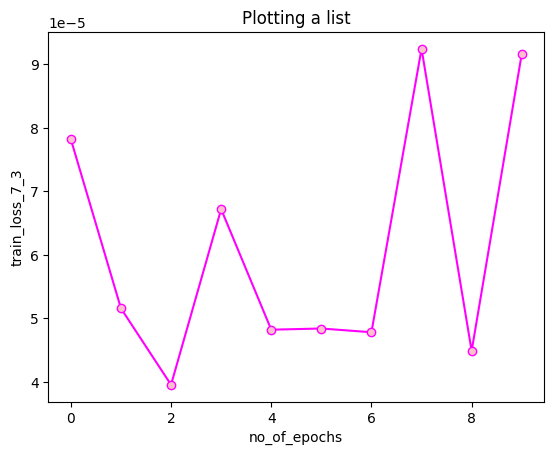

In [98]:
epoch = [epoch for epoch in range(num_epochs)]
plt.plot(epoch,train_loss_list, color='magenta', marker='o',mfc='pink' )
plt.ylabel('train_loss_7_3') #set the label for x-axis
plt.xlabel('no_of_epochs') #set the label for y axis
plt.title("Plotting a list") #set the title of the graph
plt.show() #display the graph

# Test the model and get the predicted model


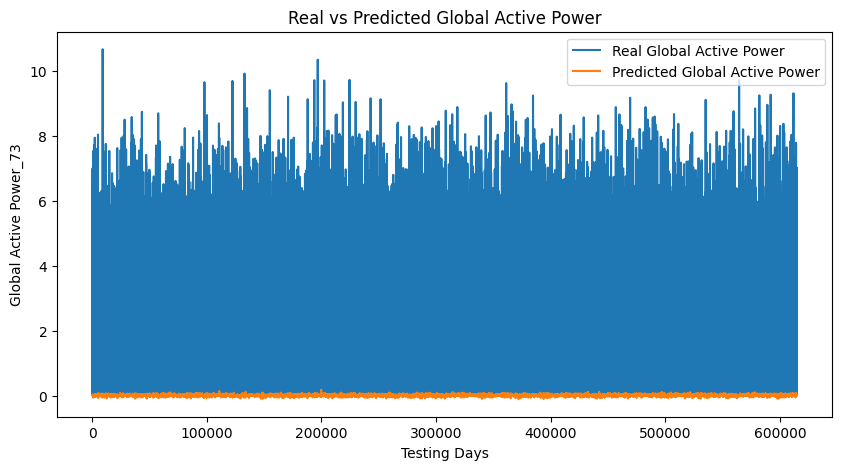

In [99]:
import matplotlib.pyplot as plt

# Set model to evaluation mode
model.eval()

# Initialize lists to store real and predicted global active power
real_global_active_power = []
predicted_global_active_power = []

# Iterate over the testing dataloader
for i, (inputs, targets) in enumerate(test_dataloader):
    inputs = (inputs - X_test_mean) / X_test_std # normalize the inputs

    # Forward pass to get predicted global active power
    outputs = model(inputs)
    predicted_global_active_power.extend(outputs.detach().numpy().tolist())

    # Append real global active power to list
    real_global_active_power.extend(targets.numpy().tolist())

# Convert the lists to numpy arrays for plotting
real_global_active_power = np.array(real_global_active_power)
predicted_global_active_power = np.array(predicted_global_active_power)

# Plot the real and predicted global active power
plt.figure(figsize=(10, 5))
plt.plot(real_global_active_power, label='Real Global Active Power')
plt.plot(predicted_global_active_power, label='Predicted Global Active Power')
plt.xlabel('Testing Days')
plt.ylabel('Global Active Power_73')
plt.legend()
plt.title('Real vs Predicted Global Active Power')
plt.show()
